# Chapter 6 - Linear Model Selection and Regularization

- [Lab 2: Ridge Regression](#6.6.1-Ridge-Regression)
- [Lab 2: The Lasso](#6.6.2-The-Lasso)
- [Lab 3: Principal Components Regression](#6.7.1-Principal-Components-Regression)
- [Lab 3: Partial Least Squares](#6.7.2-Partial-Least-Squares)

In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glmnet as gln

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

# The Credit Dataset

## Get Data

In [39]:
df = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Credit.csv', index_col=0)
# df = df.drop(df.columns[0], axis=1)
df.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580


## Encode categorical data

In [ ]:
## pandas.factorize -- Encode the object as an enumerated type or categorical variable.

In [40]:
for col in ['Gender', 'Student', 'Married']:
    df[col] = pd.factorize(df[col])[0]
if 'Ethnicity' in df.columns:
    df = pd.concat([df, pd.get_dummies(df['Ethnicity'])], axis=1)
    df.drop('Ethnicity', axis=1, inplace=True)
if 'Balance' in df.columns:
    balance = df['Balance']
    df.drop('Balance', axis=1, inplace=True)
    df['Balance'] = balance
df.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,African American,Asian,Caucasian,Balance
1,14.891,3606,283,2,34,11,0,0,0,0,0,1,333
2,106.025,6645,483,3,82,15,1,1,0,0,1,0,903
3,104.593,7075,514,4,71,11,0,0,1,0,1,0,580


In [4]:
def get_credit_data():
    df = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Credit.csv', index_col=0)
    for col in ['Gender', 'Student', 'Married']:
        df[col] = pd.factorize(df[col])[0]
    if 'Ethnicity' in df.columns:
        df = pd.concat([df, pd.get_dummies(df['Ethnicity'], prefix="Ethnicity", drop_first=True)], axis=1)
        df.drop('Ethnicity', axis=1, inplace=True)
    if 'Balance' in df.columns:
        balance = df['Balance']
        df.drop('Balance', axis=1, inplace=True)
        df['Balance'] = balance
    return df

# Best Subset Selection

To perform best subset selection, we fit a separate least squares regression for each possible combination of the p predictors.

Algorithm

1. Let $M_0$ denote the _null_ model which contains no predictors, this model simply predicts the sample mean of each observation

2.  For k=1,2,...,n:
       
       (a) Fit all ${N}\choose{k}$ models that contain exactly $k$ predictors
       
       (b) Pick the best among these ${N}\choose{k}$ models, and call it $M_k$. Here the best is defined as having the smallest RSS, or an equivalently largest $R^2$.

3. Select the single best model among $M_0, M_1, ..., M_p$ using cross validated predicton error, $C_p$, BIC, adjusted $R_2$ or any other method.

In [59]:
# credit = get_credit_data()
X = credit.iloc[:, 0:(credit.shape[1]-1)]
y = credit.iloc[:, credit.shape[1]-1]

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def model_fit(X, y):
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    RSS = mean_squared_error(y, y_pred)*len(y)
    R2 = r2_score(y, y_pred)
    return RSS, R2

In [61]:
from itertools import combinations
l_model, l_rss, l_r2, l_n_features = [], [], [], []
for k in range(1, X.shape[1]+1):
    for subset in combinations(X.columns, k):
        X_k = X[list(subset)]
        RSS, R2 = model_fit(X_k, y)
        l_model.append(subset)
        l_rss.append(RSS)
        l_r2.append(R2)
        l_n_features.append(k)
df = pd.DataFrame({'subset': l_model, 'rss': l_rss, 'r2': l_r2, 'n_features': l_n_features})
df

,subset,rss,r2,n_features
0,"(Income,)",6.620874e+07,0.214977,1
1,"(Limit,)",2.171566e+07,0.742522,1
2,"(Rating,)",2.143512e+07,0.745848,1
3,"(Cards,)",8.370950e+07,0.007475,1
4,"(Age,)",8.433963e+07,0.000003,1
...,...,...,...,...
2042,"(Income, Limit, Rating, Age, Education, Gender...",3.949432e+06,0.953172,10
2043,"(Income, Limit, Cards, Age, Education, Gender,...",3.839044e+06,0.954481,10
2044,"(Income, Rating, Cards, Age, Education, Gender...",4.117780e+06,0.951176,10
2045,"(Limit, Rating, Cards, Age, Education, Gender,...",1.461789e+07,0.826679,10


In [7]:
# from itertools import combinations
# l_model, l_rss, l_r2 = [], [], []
# for k in range(1, X.shape[1]+1):
#     min_rss, max_r2, model_k = np.inf, -np.inf, None
#     for subset in combinations(X.columns, k):
#         X_k = X[list(subset)]
#         RSS, R2 = model_fit(X_k, y)
#         if RSS < min_rss:
#             min_rss = RSS
#             max_r2 = R2
#             model_k = subset
#     l_model.append(model_k)
#     l_rss.append(min_rss)
#     l_r2.append(max_r2)
# df = pd.DataFrame({'subset': l_model, 'rss': l_rss, 'r2': l_r2})
# df

,subset,rss,r2
0,"(Rating,)",2.143512e+07,0.745848
1,"(Income, Rating)",1.053254e+07,0.875118
2,"(Income, Rating, Student)",4.227219e+06,0.949879
3,"(Income, Limit, Cards, Student)",3.915058e+06,0.953580
4,"(Income, Limit, Rating, Cards, Student)",3.866091e+06,0.954161
5,"(Income, Limit, Rating, Cards, Age, Student)",3.821620e+06,0.954688
6,"(Income, Limit, Rating, Cards, Age, Gender, St...",3.810759e+06,0.954817
7,"(Income, Limit, Rating, Cards, Age, Gender, St...",3.804746e+06,0.954888
8,"(Income, Limit, Rating, Cards, Age, Gender, St...",3.798367e+06,0.954964
9,"(Income, Limit, Rating, Cards, Age, Gender, St...",3.791345e+06,0.955047


In [62]:
df_min_rss = df[df.groupby(by='n_features')['rss'].transform(min) == df['rss']]
df_min_rss

,subset,rss,r2,n_features
2,"(Rating,)",2.143512e+07,0.745848,1
12,"(Income, Rating)",1.053254e+07,0.875118,2
79,"(Income, Rating, Student)",4.227219e+06,0.949879,3
242,"(Income, Limit, Cards, Student)",3.915058e+06,0.953580,4
564,"(Income, Limit, Rating, Cards, Student)",3.866091e+06,0.954161,5
1025,"(Income, Limit, Rating, Cards, Age, Student)",3.821620e+06,0.954688,6
1490,"(Income, Limit, Rating, Cards, Age, Gender, St...",3.810759e+06,0.954817,7
1826,"(Income, Limit, Rating, Cards, Age, Gender, St...",3.804746e+06,0.954888,8
1990,"(Income, Limit, Rating, Cards, Age, Gender, St...",3.798367e+06,0.954964,9
2040,"(Income, Limit, Rating, Cards, Age, Gender, St...",3.791345e+06,0.955047,10


In [63]:
df_min_rss = df[df.groupby(by='n_features')['rss'].transform(min) == df['rss']]
df_max_r2 = df[df.groupby(by='n_features')['r2'].transform(max) == df['r2']]
df_max_r2

,subset,rss,r2,n_features
2,"(Rating,)",2.143512e+07,0.745848,1
12,"(Income, Rating)",1.053254e+07,0.875118,2
79,"(Income, Rating, Student)",4.227219e+06,0.949879,3
242,"(Income, Limit, Cards, Student)",3.915058e+06,0.953580,4
564,"(Income, Limit, Rating, Cards, Student)",3.866091e+06,0.954161,5
1025,"(Income, Limit, Rating, Cards, Age, Student)",3.821620e+06,0.954688,6
1490,"(Income, Limit, Rating, Cards, Age, Gender, St...",3.810759e+06,0.954817,7
1826,"(Income, Limit, Rating, Cards, Age, Gender, St...",3.804746e+06,0.954888,8
1990,"(Income, Limit, Rating, Cards, Age, Gender, St...",3.798367e+06,0.954964,9
2040,"(Income, Limit, Rating, Cards, Age, Gender, St...",3.791345e+06,0.955047,10


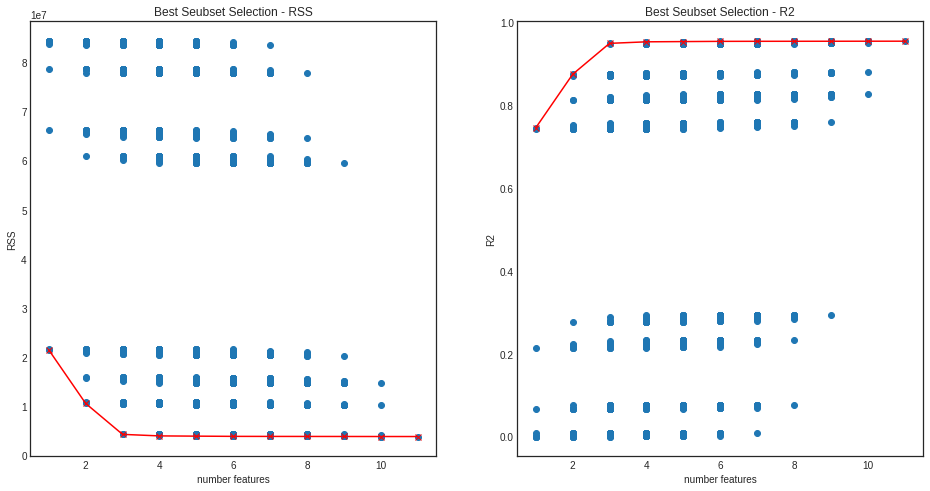

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].plot(df_min_rss.n_features, df_min_rss.rss, color='r', marker='x')
ax[0].scatter(df.n_features, df.rss)
ax[0].set_xlabel('number features')
ax[0].set_ylabel('RSS')
ax[0].set_title("Best Seubset Selection - RSS")

ax[1].plot(df_max_r2.n_features, df_max_r2.r2, color='r', marker='x')
ax[1].scatter(df.n_features, df.r2)
ax[1].set_xlabel('number features')
ax[1].set_ylabel('R2')
ax[1].set_title("Best Seubset Selection - R2")

plt.show()

## Forward stepwise selection

In [54]:
from itertools import combinations

l_model, l_rss, l_r2, l_n_features = [], [], [], []

remaining_features = list(X.columns)
included_features = []

for k in range(1, X.shape[1]+1):
    min_rss, max_r2, best_feature = np.inf, -np.inf, None
    for subset in combinations(remaining_features, 1):
        X_k = X[list(subset) + included_features]
        RSS, R2 = model_fit(X_k, y)
        if RSS < min_rss:
            min_rss = RSS
            max_r2 = R2
            best_feature = subset[0]
        l_model.append(X_k.columns.values)
        l_rss.append(RSS)
        l_r2.append(R2)
        l_n_features.append(k)

    included_features.append(best_feature)
    remaining_features.remove(best_feature)
    
#     l_model.append(included_features.copy())
#     l_rss.append(min_rss)
#     l_r2.append(max_r2)
#     l_n_features.append(k)
    
df = pd.DataFrame({'subset': l_model, 'rss': l_rss, 'r2': l_r2, 'n_features': l_n_features})
df

,subset,rss,r2,n_features
0,[Income],6.620874e+07,0.214977,1
1,[Limit],2.171566e+07,0.742522,1
2,[Rating],2.143512e+07,0.745848,1
3,[Cards],8.370950e+07,0.007475,1
4,[Age],8.433963e+07,0.000003,1
...,...,...,...,...
61,"[Married, Rating, Income, Student, Limit, Card...",3.798367e+06,0.954964,9
62,"[Ethnicity_Caucasian, Rating, Income, Student,...",3.798730e+06,0.954959,9
63,"[Education, Rating, Income, Student, Limit, Ca...",3.793418e+06,0.955022,10
64,"[Ethnicity_Caucasian, Rating, Income, Student,...",3.791345e+06,0.955047,10


In [55]:
df_min_rss = df[df.groupby(by='n_features')['rss'].transform(min) == df['rss']]
df_max_r2 = df[df.groupby(by='n_features')['r2'].transform(max) == df['r2']]

In [ ]:
df_min_rss

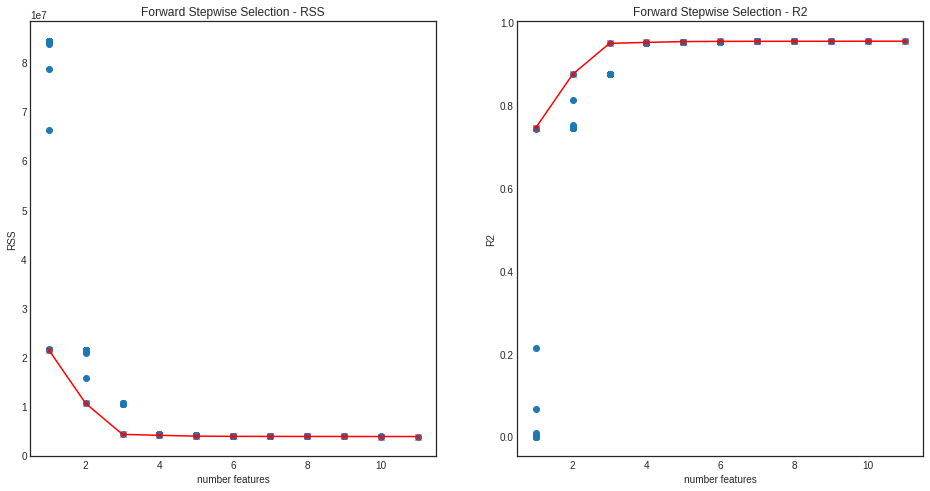

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].plot(df_min_rss.n_features, df_min_rss.rss, color='r', marker='x')
ax[0].scatter(df.n_features, df.rss)
ax[0].set_xlabel('number features')
ax[0].set_ylabel('RSS')
ax[0].set_title("Forward Stepwise Selection - RSS")

ax[1].plot(df_max_r2.n_features, df_max_r2.r2, color='r', marker='x')
ax[1].scatter(df.n_features, df.r2)
ax[1].set_xlabel('number features')
ax[1].set_ylabel('R2')
ax[1].set_title("Forward Stepwise Selection - R2")

plt.show()

## Backward stepwise selection

In [49]:
from itertools import combinations

l_model, l_rss, l_r2, l_n_features = [], [], [], []

included_features = list(X.columns)
p = X.shape[1]

for k in range(p, 1, -1):
    min_rss, max_r2, best_subset_k = np.inf, -np.inf, None
    for subset in combinations(included_features, 1):
        included_features.remove(subset[0])
        X_k = X[included_features]
        RSS, R2 = model_fit(X_k, y)
        if RSS < min_rss:
            min_rss = RSS
            max_r2 = R2
            best_subset_k = list(X_k.columns)
        
        l_model.append(X_k.columns.values)
        l_rss.append(RSS)
        l_r2.append(R2)
        l_n_features.append(k-1)
        
        included_features.append(subset[0])
        
    included_features = best_subset_k.copy()

df = pd.DataFrame({'subset': l_model, 'rss': l_rss, 'r2': l_r2, 'n_features': l_n_features})
df

,subset,rss,r2,n_features
0,"[Limit, Rating, Cards, Age, Education, Gender,...",1.461789e+07,0.826679,10
1,"[Rating, Cards, Age, Education, Gender, Studen...",4.117780e+06,0.951176,10
2,"[Cards, Age, Education, Gender, Student, Marri...",3.839044e+06,0.954481,10
3,"[Age, Education, Gender, Student, Married, Eth...",3.949432e+06,0.953172,10
4,"[Education, Gender, Student, Married, Ethnicit...",3.829288e+06,0.954597,10
...,...,...,...,...
60,"[Income, Limit]",1.087083e+07,0.871107,2
61,"[Limit, Student]",1.582835e+07,0.812327,2
62,"[Student, Income]",6.093905e+07,0.277459,2
63,[Limit],2.171566e+07,0.742522,1


In [51]:
df_min_rss = df[df.groupby(by='n_features')['rss'].transform(min) == df['rss']]
df_max_r2 = df[df.groupby(by='n_features')['r2'].transform(max) == df['r2']]

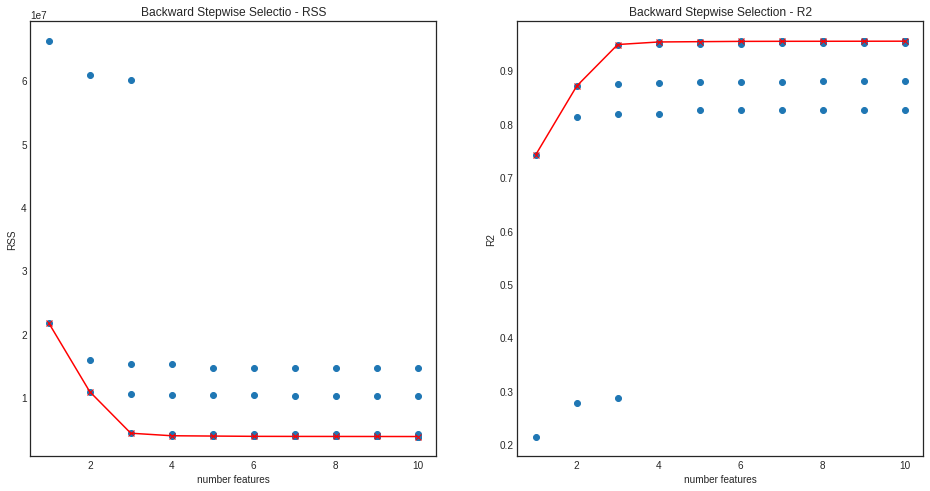

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].plot(df_min_rss.n_features, df_min_rss.rss, color='r', marker='x')
ax[0].scatter(df.n_features, df.rss)
ax[0].set_xlabel('number features')
ax[0].set_ylabel('RSS')
ax[0].set_title("Backward Stepwise Selectio - RSS")

ax[1].plot(df_max_r2.n_features, df_max_r2.r2, color='r', marker='x')
ax[1].scatter(df.n_features, df.r2)
ax[1].set_xlabel('number features')
ax[1].set_ylabel('R2')
ax[1].set_title("Backward Stepwise Selection - R2")

plt.show()

# Comparing models: AIC, BIC, Mallows'CP

In [64]:
df1 = df_min_rss.copy()
n = len(y)
p = X.shape[1]

hat_sigma_squared = (1/(n - p -1)) * min(df1['rss'])

# Computing
df1['C_p'] = (1/n) * (df1['rss'] + 2 * df1['n_features'] * hat_sigma_squared )
df1['AIC'] = (1/(n*hat_sigma_squared)) * (df1['rss'] + 2 * df1['n_features'] * hat_sigma_squared )
df1['BIC'] = (1/(n*hat_sigma_squared)) * (df1['rss'] +  np.log(n) * df1['n_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['r2'])*(n-1)/(n-df1['n_features'] -1))

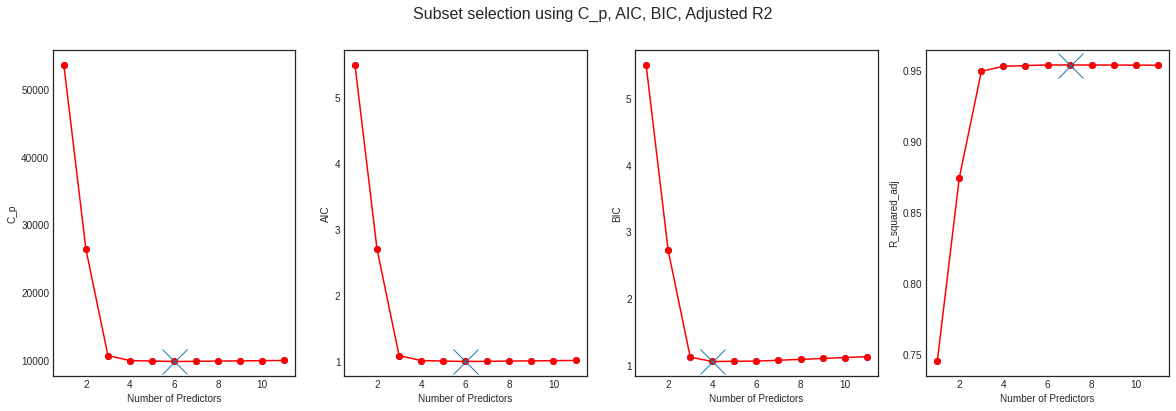

In [65]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']

fig, ax = plt.subplots(1, 4, figsize = (20,6))
for i,v in enumerate(variables):
    ax[i].plot(df1['n_features'], df1[v], marker='o', color='r')
    ax[i].scatter(df1['n_features'], df1[v], marker='o')
    if v == 'R_squared_adj':
        idx_max = df1[v].idxmax()
        ax[i].plot(df1['n_features'][idx_max], df1[v][idx_max], marker='x', markersize=25)
    else:
        idx_min = df1[v].idxmin()
        ax[i].plot(df1['n_features'][idx_min], df1[v][idx_min], marker='x', markersize=25)

    ax[i].set_xlabel('Number of Predictors')
    ax[i].set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

# Ridge Regression

In [100]:
# credit = get_credit_data()
X = credit.iloc[:, 0:(credit.shape[1]-1)]
y = credit.iloc[:, credit.shape[1]-1]

## Standarize the feature matrix

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [102]:
X.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity_Asian,Ethnicity_Caucasian
0,-0.861583,-0.489999,-0.465539,-0.699130,-1.257674,-0.784930,-1.035635,-0.333333,-0.795395,-0.585049,1.005013
1,1.727437,0.828261,0.828703,0.031032,1.528451,0.496588,0.965592,3.000000,-0.795395,1.709260,-0.995012
2,1.686756,1.014787,1.029311,0.761194,0.889964,-0.784930,-1.035635,-0.333333,1.257237,1.709260,-0.995012
3,2.946152,2.068440,2.110003,0.031032,-1.141586,-0.784930,0.965592,-0.333333,1.257237,1.709260,-0.995012
4,0.302928,0.070012,0.013331,-0.699130,0.715831,0.816968,-1.035635,-0.333333,-0.795395,-0.585049,1.005013


## Perform ridge regression on standarized data using default $\lambda = 1.0$

In [103]:
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X, y)
print('alpha=', model.alpha)
print('coefficients=', model.coef_)

alpha= 1.0
coefficients= [-271.27181809  367.16879622  245.25866833   21.33059812  -10.89650917
   -3.01362181   -5.22288527  126.86417618    4.71833482    7.60073898
    5.08311489]


In [104]:
from sklearn.linear_model import Ridge

alphas = []
base = [1, 2, 5]
for m in [1, 10, 100, 1000]:
    for v in base:
        alphas.append(m*v)
alphas

[1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

In [160]:
from sklearn.linear_model import Ridge
coef = {}
alphas = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X, y)
    coef[a] = model.coef_

In [162]:
df_coef = pd.DataFrame(coef).T
df_coef.columns = X.columns
df_coef

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity_Asian,Ethnicity_Caucasian
1,-271.271818,367.168796,245.258668,21.330598,-10.896509,-3.013622,-5.222885,126.864176,4.718335,7.600739,5.083115
2,-267.820742,344.135630,264.858362,20.542444,-11.167329,-2.853968,-5.115300,126.320730,4.911896,7.625266,5.081053
5,-257.754731,318.816665,280.064346,20.042720,-11.901108,-2.604807,-4.797358,124.986755,5.165389,7.485973,5.046388
10,-242.124545,301.986087,281.045146,20.211677,-12.974819,-2.336418,-4.302776,122.991272,5.383855,7.154613,4.970533
20,-214.703670,282.838796,271.986829,20.871395,-14.706748,-1.927976,-3.439553,119.321863,5.658537,6.514256,4.805257
50,-154.346486,247.280852,243.074587,22.123252,-17.702952,-1.116100,-1.575375,109.901290,6.027813,5.035992,4.298668
100,-94.597784,211.391442,209.601376,22.356504,-19.035029,-0.423652,0.179193,97.638749,6.011495,3.512579,3.544476
200,-37.294613,171.427463,170.875244,20.676255,-17.539115,0.054173,1.658089,80.380279,5.344906,1.973135,2.454234
500,11.048906,119.576160,119.635204,15.198983,-11.023567,0.098160,2.356604,53.052543,3.459937,0.487726,0.975622
1000,22.934668,84.077157,84.216136,10.266370,-5.694470,-0.096124,1.994611,34.007392,1.957909,-0.080998,0.279720


In [146]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
model.coef_
beta_l2 = np.sqrt(np.sum(model.coef_ * model.coef_))
beta_l2

563.1411959775545

In [147]:
df_coef_2 = df_coef.copy()

In [148]:
df_coef_2 = df_coef.copy()
coef_l2 = df_coef_2 * df_coef_2
df_coef_2['beta_ratio'] = np.sqrt(coef_l2.sum(axis=1))/beta_l2
df_coef_2

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity_Asian,Ethnicity_Caucasian,beta_ratio
1,-271.271818,367.168796,245.258668,21.330598,-10.896509,-3.013622,-5.222885,126.864176,4.718335,7.600739,5.083115,0.948598
2,-267.820742,344.135630,264.858362,20.542444,-11.167329,-2.853968,-5.115300,126.320730,4.911896,7.625266,5.081053,0.934514
5,-257.754731,318.816665,280.064346,20.042720,-11.901108,-2.604807,-4.797358,124.986755,5.165389,7.485973,5.046388,0.910358
10,-242.124545,301.986087,281.045146,20.211677,-12.974819,-2.336418,-4.302776,122.991272,5.383855,7.154613,4.970533,0.878305
20,-214.703670,282.838796,271.986829,20.871395,-14.706748,-1.927976,-3.439553,119.321863,5.658537,6.514256,4.805257,0.823527
50,-154.346486,247.280852,243.074587,22.123252,-17.702952,-1.116100,-1.575375,109.901290,6.027813,5.035992,4.298668,0.703658
100,-94.597784,211.391442,209.601376,22.356504,-19.035029,-0.423652,0.179193,97.638749,6.011495,3.512579,3.544476,0.583638
200,-37.294613,171.427463,170.875244,20.676255,-17.539115,0.054173,1.658089,80.380279,5.344906,1.973135,2.454234,0.460376
500,11.048906,119.576160,119.635204,15.198983,-11.023567,0.098160,2.356604,53.052543,3.459937,0.487726,0.975622,0.317254
1000,22.934668,84.077157,84.216136,10.266370,-5.694470,-0.096124,1.994611,34.007392,1.957909,-0.080998,0.279720,0.224544


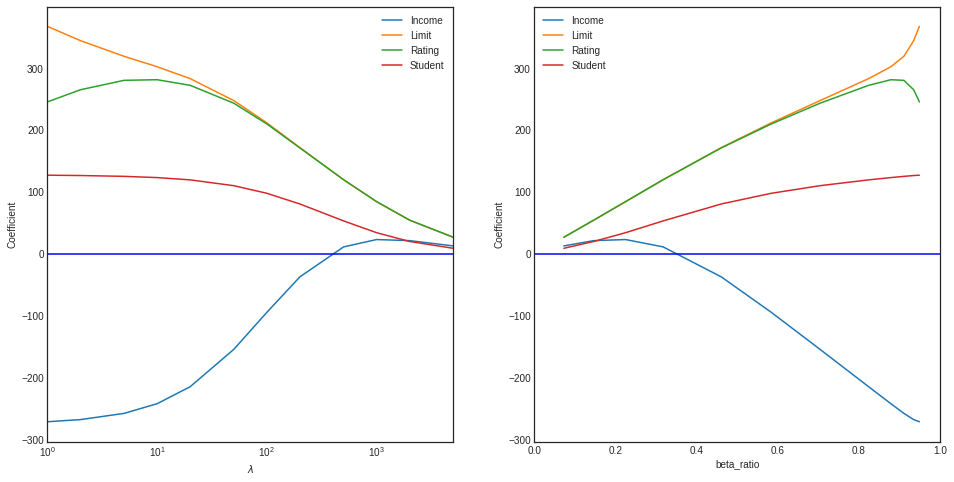

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
for col in ['Income', 'Limit', 'Rating', 'Student']:
    sns.lineplot(x=df_coef.index, y=df_coef[col], label=col, ax=ax[0])
ax[0].set_xlim(1, 5000)
ax[0].axhline(0, color='b')
ax[0].set_xscale("log")
ax[0].set_xlabel("$\lambda$")
ax[0].set_ylabel('Coefficient')


# sns.lineplot(x='beta_ratio', y='Income', 'Limit', 'Rating', "Student"], data=df_coef_2, ax=ax[1])
for col in ['Income', 'Limit', 'Rating', 'Student']:
    sns.lineplot(x='beta_ratio', y=col, label = col, data=df_coef_2, ax=ax[1])
ax[1].set_xlim(0.0, 1.0)
ax[1].axhline(0, color='b')
ax[1].set_ylabel('Coefficient')

plt.show()

# Ridge CV

In [171]:
from sklearn.linear_model import RidgeCV
ridgecv = RidgeCV(scoring='neg_mean_squared_error')
_ = ridgecv.fit(X, y)

In [172]:
ridgecv.alpha_, ridgecv.best_score_

(0.3289666123287841, -10064.646314652906)

# The Lasso

In [176]:
from sklearn.linear_model import Lasso, LarsCV

coef = {}
alphas = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
for a in alphas:
    model = Lasso(alpha=a)
    model.fit(X, y)
    coef[a] = model.coef_

In [180]:
lassocv = LarsCV()
_ = lassocv.fit(X, y)

In [183]:
print(lassocv.cv_alphas_)
print(lassocv.alpha_)

[ 0.          0.02897983  0.04323457  0.05291136  0.05740757  0.06088893
  0.10225735  0.12759442  0.13681595  0.15884148  0.17576509  0.19055154
  0.20071513  0.21031372  0.22704542  0.25351479  0.27421571  0.2793198
  0.28864366  0.29256373  0.31216906  0.33523545  0.38431281  0.43324928
  0.45143527  0.54326194  0.79450409  0.83735325  0.89448207  0.90473386
  0.99181231  0.99648428  1.01126024  1.10910868  1.28018727  1.4047268
  2.70670201  3.00144404  3.10050944  3.19441341  3.20296215  3.46890898
  4.59022888  5.91080632  6.22460468  6.30191296  6.76855556  7.07380892
  7.37852633 12.57035784 19.4366936  21.71386707 21.99523093 22.21324281
 22.40185125 22.45516546]
0.02897983049505447


# Lab 2

In [ ]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
df = pd.read_csv('Data/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

In [ ]:
df.head()

In [ ]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

In [ ]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

In [ ]:
X.head(5)

#### I executed the R code and downloaded the exact same training/test sets used in the book.

In [ ]:
X_train = pd.read_csv('Data/Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('Data/Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Data/Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Data/Hitters_y_test.csv', index_col=0)

### 6.6.1 Ridge Regression

### Scikit-learn

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:
### $$ \frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to
### $$ \frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 $$
The __sklearn Ridge()__ function optimizes:
### $$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
### $$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$

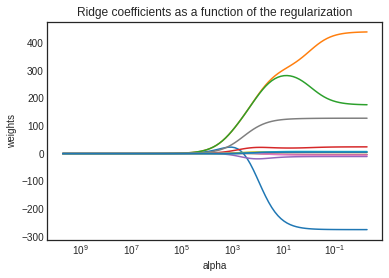

In [163]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### Alpha = 4

In [165]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

NameError: name 'X_train' is not defined

In [ ]:
ridge2 = Ridge(alpha=len(X_)*11498/2)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
mean_squared_error(y_test, pred)

In [ ]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

#### Alpha = $10^{10}$ 
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [164]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

NameError: name 'ridge2' is not defined

#### Compute the regularization path using RidgeCV

In [166]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

NameError: name 'X_train' is not defined

In [ ]:
ridgecv.alpha_

In [ ]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))

In [ ]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

### python-glmnet (update 2016-08-29)
This relatively new module is a wrapper for the fortran library used in the R package `glmnet`. It gives mostly the exact same results as described in the book. However, the `predict()` method does not give you the regression *coefficients* for lambda values not in the lambda_path. It only returns the predicted values.
https://github.com/civisanalytics/python-glmnet

In [ ]:
grid = 10**np.linspace(10,-2,100)

ridge3 = gln.ElasticNet(alpha=0, lambda_path=grid)
ridge3.fit(X, y)

#### Lambda 11498

In [ ]:
ridge3.lambda_path_[49]

In [ ]:
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[49]))

In [ ]:
pd.Series(np.round(ridge3.coef_path_[:,49], decimals=3), index=X.columns)

In [ ]:
np.sqrt(np.sum(ridge3.coef_path_[:,49]**2))

#### Lambda 705

In [ ]:
ridge3.lambda_path_[59]

In [ ]:
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[59]))

In [ ]:
pd.Series(np.round(ridge3.coef_path_[:,59], decimals=3), index=X.columns)

In [ ]:
np.sqrt(np.sum(ridge3.coef_path_[:,59]**2))

#### Fit model using just the training set.

In [ ]:
ridge4 = gln.ElasticNet(alpha=0, lambda_path=grid, scoring='mean_squared_error', tol=1e-12)
ridge4.fit(X_train, y_train.values.ravel())

In [ ]:
# prediction using lambda = 4
pred = ridge4.predict(X_test, lamb=4)
mean_squared_error(y_test.values.ravel(), pred)

#### Lambda chosen by cross validation

In [ ]:
ridge5 = gln.ElasticNet(alpha=0, scoring='mean_squared_error')
ridge5.fit(X_train, y_train.values.ravel())

In [ ]:
# Lambda with best CV performance
ridge5.lambda_max_

In [ ]:
# Lambda larger than lambda_max_, but with a CV score that is within 1 standard deviation away from lambda_max_ 
ridge5.lambda_best_

In [ ]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(ridge5.lambda_path_), -ridge5.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=ridge5.cv_standard_error_, ecolor='lightgrey', capsize=4)

for ref, txt in zip([ridge5.lambda_best_, ridge5.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [ ]:
# MSE for lambda with best CV performance
pred = ridge5.predict(X_test, lamb=ridge5.lambda_max_)
mean_squared_error(y_test, pred)

#### Fit model to full data set

In [ ]:
ridge6= gln.ElasticNet(alpha=0, scoring='mean_squared_error', n_splits=10)
ridge6.fit(X, y)

In [ ]:
# These are not really close to the ones in the book.
pd.Series(ridge6.coef_path_[:,ridge6.lambda_max_inx_], index=X.columns)

### 6.6.2 The Lasso

### Scikit-learn



For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

In [ ]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [ ]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.values.ravel())

In [ ]:
lassocv.alpha_

In [ ]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

In [ ]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

### python-glmnet

In [ ]:
lasso2 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error', n_splits=10)
lasso2.fit(X_train, y_train.values.ravel())

In [ ]:
l1_norm = np.sum(np.abs(lasso2.coef_path_), axis=0)

plt.figure(figsize=(10,6))
plt.plot(l1_norm, lasso2.coef_path_.T)
plt.xlabel('L1 norm')
plt.ylabel('Coefficients');

#### Let glmnet() create a grid to use in CV

In [ ]:
lasso3 = gln.ElasticNet(alpha=1, scoring='mean_squared_error', n_splits=10)
lasso3.fit(X_train, y_train.values.ravel())

In [ ]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(lasso3.lambda_path_), -lasso3.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=lasso3.cv_standard_error_, ecolor='lightgrey', capsize=4)

for ref, txt in zip([lasso3.lambda_best_, lasso3.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [ ]:
pred = lasso3.predict(X_test, lamb=lasso3.lambda_max_)
mean_squared_error(y_test, pred)

#### Fit model on full dataset

In [ ]:
lasso4 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error', n_splits=10)
lasso4.fit(X, y)

In [ ]:
# These are not really close to the ones in the book.
pd.Series(lasso4.coef_path_[:,lasso4.lambda_max_inx_], index=X.columns)

# Lab 3

### 6.7.1 Principal Components Regression

Scikit-klearn does not have an implementation of PCA and regression combined like the 'pls' package in R.
https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf

In [ ]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

The above loadings are the same as in R.

In [ ]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

The above principal components are the same as in R.

In [ ]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

In [ ]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 18 components.

In [ ]:
regr_test = LinearRegression()
regr_test.fit(X_reduced, y)
regr_test.coef_

#### Fitting PCA with training data

In [ ]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 6 components.

#### Transform test data with PCA loadings and fit regression on 6 principal components

In [ ]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

### 6.7.2 Partial Least Squares

Scikit-learn PLSRegression gives same results as the pls package in R when using 'method='oscorespls'. In the LAB excercise, the standard method is used which is 'kernelpls'. 

When doing a slightly different fitting in R, the result is close to the one obtained using scikit-learn.

    pls.fit=plsr(Salary~., data=Hitters, subset=train, scale=TRUE, validation="CV", method='oscorespls')
    validationplot(pls.fit,val.type="MSEP", intercept = FALSE)
   
See documentation:
http://scikit-learn.org/dev/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression

In [ ]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [ ]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))